In [37]:
import joblib
import torch
import torch.nn as nn
from dataset import CircleImageDataset
from torch.utils.data import DataLoader
from utils import CircleParams
from metrics import thresholded_iou
import numpy as np

import matplotlib.pyplot as plt
from model import CNN

In [38]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

In [39]:
batch_size = 32 

In [40]:
train_dataset = CircleImageDataset(max_noise=0.6, device=device,)
test_dataset = CircleImageDataset(fixed=True, max_noise=0.6, img_transform=train_dataset.img_transform, device=device)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset)

In [48]:
net = CNN()
net.to(device)

optimizer = torch.optim.Adam(net.parameters(), lr=3e-4)

In [49]:
criterion = nn.MSELoss()

In [50]:
epochs = 150 
losses = []
val_losses = []

for epoch in range(epochs):
    batch_losses = []
    net.train()
    for i, (imgs, circles) in enumerate(train_dataloader):
        optimizer.zero_grad()

        y = net(imgs)

        loss = criterion(y, circles)
        batch_losses.append(loss.item())

        loss.backward()

        optimizer.step()

    losses.append(np.mean(batch_losses))

    actual_circles = []
    pred_circles = []
    net.eval()
    for i, (img, circle) in enumerate(test_dataloader):
        circle = circle.squeeze()
        actual_circles.append(train_dataset.circle_transform.inverse_transform(
            CircleParams(radius=circle[0].item(), col=circle[1].item(), row=circle[2].item())))

        y = net(img)

        rad_mu = y[:, 0].squeeze() # Radius mean
        col_mu = y[:, 1].squeeze() # Col mean
        row_mu = y[:, 2].squeeze() # Row mean

        pred_circles.append(train_dataset.circle_transform.inverse_transform(
            CircleParams(radius=rad_mu.item(), row=row_mu.item(), col=col_mu.item())))
    
    val_loss = thresholded_iou(actual_circles, pred_circles, thresh=0.75)

    if val_losses and val_loss > max(val_losses):
        print(f'model saved at epoch {epoch}, metric: {val_loss}')
        torch.save(net.state_dict(), 'training_checkpoints/best_epoch.pt')

    val_losses.append(val_loss)

    print(f"train_loss {losses[-1]}, val_loss:  {val_losses[-1]}")

train_loss 1.0923376567661762, val_loss:  0.002
train_loss 1.0157399382442236, val_loss:  0.001
train_loss 1.0505313035100698, val_loss:  0.002
model saved at epoch 3, metric: 0.003
train_loss 1.0027767587453127, val_loss:  0.003
model saved at epoch 4, metric: 0.004
train_loss 0.8463363777846098, val_loss:  0.004
model saved at epoch 5, metric: 0.009
train_loss 0.6635364834219217, val_loss:  0.009
model saved at epoch 6, metric: 0.034
train_loss 0.5428057322278619, val_loss:  0.034
model saved at epoch 7, metric: 0.049
train_loss 0.4271703874692321, val_loss:  0.049
model saved at epoch 8, metric: 0.063
train_loss 0.3398630111478269, val_loss:  0.063
model saved at epoch 9, metric: 0.104
train_loss 0.27654728991910815, val_loss:  0.104
model saved at epoch 10, metric: 0.132
train_loss 0.27596983406692743, val_loss:  0.132
model saved at epoch 11, metric: 0.185
train_loss 0.24627124099060893, val_loss:  0.185
model saved at epoch 12, metric: 0.198
train_loss 0.23843856062740088, val_lo

In [56]:
joblib.dump(train_dataset.img_transform, 'training_checkpoints/img_transform.joblib')

['training_checkpoints/img_transform.joblib']

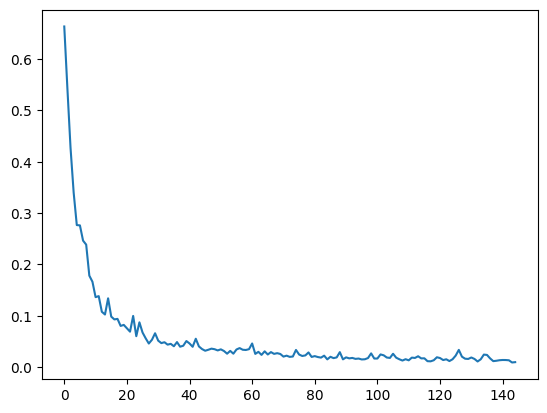

In [53]:
plt.plot(losses[5:])

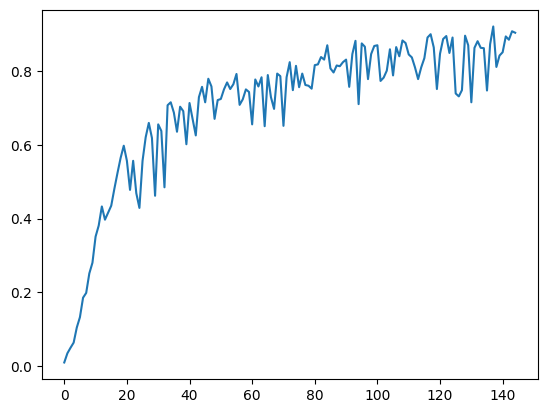

In [52]:
plt.plot(val_losses[5:])